# 【第1回_Beginner限定コンペ】銀行の顧客ターゲティング

顧客の属性情報などから定期預金キャンペーンの反応率を予測しよう。

https://signate.jp/competitions/292

Neural Network編

## ライブラリインポート

In [86]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

#import optuna
import tensorflow as tf

from tensorflow.keras import regularizers
from tensorflow.keras import backend as K
from tensorflow.keras.backend import clear_session
from tensorflow.keras.layers import Activation, Dense, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam

from imblearn.under_sampling import RandomUnderSampler

from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score

## データ読み込み・前処理

In [87]:
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')
submit_df = pd.read_csv('submit_sample.csv', header=None)

In [88]:
# one hot encoding
train_df = pd.get_dummies(train_df, columns=['job', 'marital', 'education', 'contact', 'poutcome'])
test_df = pd.get_dummies(test_df, columns=['job', 'marital', 'education', 'contact', 'poutcome'])
test_df.drop(['job_unknown'], axis=1, inplace=True)

df_list = [train_df, test_df]

for df in df_list:
    #df['default'] = df['default'].map({'yes': 1, 'no': 0})
    df.drop(['default'], axis=1, inplace=True)

    df['housing'] = df['housing'].map({'yes': 1, 'no': 0})
    #df.drop(['housing'], axis=1, inplace=True)
    
    df['loan'] = df['loan'].map({'yes': 1, 'no': 0})
    #df.drop(['loan'], axis=1, inplace=True)
    
    df['month'] = df['month'].map({'jan': 1, 'feb': 2, 'mar': 3, 'apr': 4, 'may': 5, 'jun': 6, 'jul': 7, 'aug': 8, 'sep': 9, 'oct': 10, 'nov': 11, 'dec': 12})
    #df.drop(['day', 'month'], axis=1, inplace=True)
    
    # Feb 30 とかあって、正確には変換できない
    #df['days'] = pd.to_datetime('2016/' + df['month'].astype(str).str.pad(2,fillchar='0') + '/' + df['day'].astype(str).str.pad(2,fillchar='0'), format='%Y/%m/%d').dt.strftime('%j')
    df['days'] = df['month'] * 31 + df['day']
    
    df.drop(['id'], axis=1, inplace=True)
    
y = train_df.pop('y')

# 正規化
scaler = preprocessing.StandardScaler()

_train = train_df.values
_test = test_df.values

train_scaled = scaler.fit_transform(_train)
test_scaled = scaler.fit_transform(_test)


In [89]:
print(train_scaled.shape)
print(test_scaled.shape)
print(y.shape)

(27100, 36)
(18050, 36)
(27100,)


In [90]:
train_scaled[:5]

array([[-0.64906696, -1.11812654,  0.84447012, -0.38187554,  0.49623316,
         2.3381463 , -0.62617245,  1.28856235,  0.25983994, -0.23428177,
        -0.3650682 , -0.53079949, -0.21099111, -0.16917194, -0.49572967,
        -0.19614619, -0.2117532 ,  3.15709039, -0.11488142, -0.47068683,
        -0.17384588, -0.31420198,  0.73677736, -0.59581876, -0.37422532,
         0.83577934, -0.57519141, -0.20363327,  0.64448843, -0.20607783,
        -0.5815544 , -0.33381147,  5.63992169, -0.13111408, -2.40277062,
         2.40694526],
       [-0.90494341, -0.14710508, -1.18417452, -0.38187554,  0.61292704,
         0.93471994, -0.34803707,  0.23596131,  1.06889503, -0.23428177,
        -0.3650682 , -0.53079949,  4.73953621, -0.16917194, -0.49572967,
        -0.19614619, -0.2117532 , -0.31674735, -0.11488142, -0.47068683,
        -0.17384588, -0.31420198, -1.35726212,  1.67836272, -0.37422532,
        -1.19648806,  1.73855169, -0.20363327,  0.64448843, -0.20607783,
        -0.5815544 , -0.33381

In [91]:
#precision
def P(y_true, y_pred):
    true_positives = K.sum(K.cast(K.greater(K.clip(y_true * y_pred, 0, 1), 0.10), 'float32'))
    pred_positives = K.sum(K.cast(K.greater(K.clip(y_pred, 0, 1), 0.10), 'float32'))

    precision = true_positives / (pred_positives + K.epsilon())
    return precision

#recall
def R(y_true, y_pred):
    true_positives = K.sum(K.cast(K.greater(K.clip(y_true * y_pred, 0, 1), 0.10), 'float32'))
    poss_positives = K.sum(K.cast(K.greater(K.clip(y_true, 0, 1), 0.10), 'float32'))

    recall = true_positives / (poss_positives + K.epsilon())
    return recall

#f-measure
def F(y_true, y_pred):
    p_val = P(y_true, y_pred)
    r_val = R(y_true, y_pred)
    f_val = 2*p_val*r_val / (p_val + r_val)

    return f_val

## 学習1サイクル

In [92]:
BATCHSIZE=32
EPOCHS = 10

In [93]:
# Clear clutter from previous Keras session graphs.
clear_session()

x_train, x_test, y_train, y_test = train_test_split(train_scaled, y, test_size=0.2, random_state=42)



model = Sequential()
model.add(Dense(units=1024, input_shape=(36,), kernel_initializer='he_uniform'))
model.add(Dense(1024, activation='relu', kernel_regularizer=regularizers.l2(0.01)))
model.add(Dropout(0.15))
model.add(Dense(1024, activation='relu', kernel_regularizer=regularizers.l2(0.01)))
model.add(Dense(1024, activation='relu', kernel_regularizer=regularizers.l2(0.01)))
model.add(Dropout(0.15))
model.add(Dense(1024, activation='relu', kernel_regularizer=regularizers.l2(0.01)))
model.add(Dense(10, activation='relu'))    
model.add(Dense(1, activation="sigmoid"))

model.compile(
    loss="binary_crossentropy", optimizer=Adam(), metrics=['accuracy', P, R, F]
)

model.summary()


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 1024)              37888     
_________________________________________________________________
dense_1 (Dense)              (None, 1024)              1049600   
_________________________________________________________________
dropout (Dropout)            (None, 1024)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 1024)              1049600   
_________________________________________________________________
dense_3 (Dense)              (None, 1024)              1049600   
_________________________________________________________________
dropout_1 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 1024)              1

In [94]:
history = model.fit(
    x_train,
    y_train,
    validation_data=(x_test, y_test),
    shuffle=True,
    batch_size=BATCHSIZE,
    epochs=EPOCHS,
    verbose=1,
)


Epoch 1/10
678/678 [==============================] - 6s 9ms/step - loss: 1.5656 - accuracy: 0.9208 - P: 0.1586 - R: 0.6115 - F: nan - val_loss: 0.2888 - val_accuracy: 0.9236 - val_P: 0.2019 - val_R: 0.5866 - val_F: nan
Epoch 2/10
678/678 [==============================] - 6s 8ms/step - loss: 0.2727 - accuracy: 0.9221 - P: 0.2171 - R: 0.5158 - F: nan - val_loss: 0.2479 - val_accuracy: 0.9301 - val_P: 0.2440 - val_R: 0.5443 - val_F: nan
Epoch 3/10
678/678 [==============================] - 6s 8ms/step - loss: 0.2563 - accuracy: 0.9252 - P: 0.2300 - R: 0.4853 - F: nan - val_loss: 0.2471 - val_accuracy: 0.9304 - val_P: 0.2033 - val_R: 0.5950 - val_F: nan
Epoch 4/10
678/678 [==============================] - 6s 8ms/step - loss: 0.2506 - accuracy: 0.9252 - P: 0.2415 - R: 0.4802 - F: nan - val_loss: 0.2378 - val_accuracy: 0.9295 - val_P: 0.2732 - val_R: 0.4815 - val_F: nan
Epoch 5/10
678/678 [==============================] - 6s 8ms/step - loss: 0.2500 - accuracy: 0.9250 - P: 0.2321 - R: 0.4

Test loss: 0.23354940116405487
Test accuracy: 0.9306272864341736
Test precision: 0.22600001096725464
Test recall: 0.5403921604156494
Test f1_score: nan


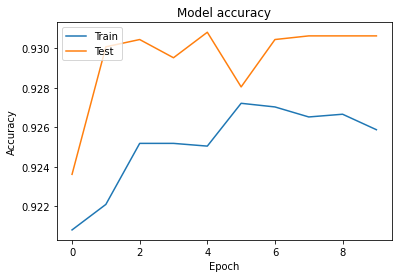

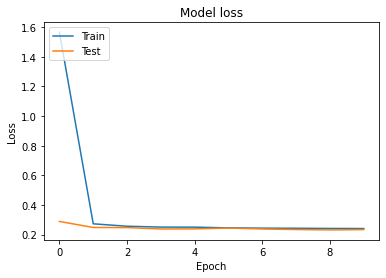

In [95]:
# Evaluate the model accuracy on the test set.
loss, accuracy, precision, recall, f1_score = model.evaluate(x_test, y_test, verbose=0)

score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', loss)
print('Test accuracy:', accuracy)
print('Test precision:', precision)
print('Test recall:', recall)
print('Test f1_score:', f1_score)

# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [96]:
test_pred = model.predict(test_df)

In [97]:
submit_df[1] = test_pred
submit_df.to_csv('submit.csv', header=False, index=False)